This notebook is mainly based on the "numerical recipes in C" book, by William H. Press et al.

## Minimization or Maximization of Functions (part I)

Liantsoa F. Randrianjanahary, Postdoctoral Fellow
Astrophysics Research Center
School of mathematics, Statistics and Computer Sciences
UKZN, Westville Campus

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
path_data = "/home/liantsoa/Pictures/"

## Overview of Maximization & Minization problem (Optimization)

The mathematical process of finding the maximum or minimum of a function is a foundational tool across science. Techniques vary from analytical approaches using calculus (e.g., setting derivatives to zero to find stationary points) to numerical methods such as gradient descent, Newton's method, or genetic algorithms. In physics, optimization underlies variational principles, where the path or configuration of a physical system minimizes (or maximizes) a quantity such as action (in classical mechanics), entropy (in thermodynamics), or energy (in quantum and statistical systems). More advanced tasks, like Bayesian inference in cosmology, also involve maximizing the posterior probability (MAP estimation) or marginal likelihoods. Moreover, optimization plays a critical role in machine learning applications in cosmology, where loss functions are minimized to train models that can classify cosmic structures or reconstruct density fields. Whether identifying physical laws, fitting theoretical models to data, or discovering latent cosmic parameters, optimization serves as the computational and conceptual backbone of inquiry in the mathematical sciences.

Optimization algorithms are often classified into two main categories based:

I- Derivative-Free Methods

II- Gradient-Based Methods



## I- Derivative-Free Methods

Advantages:

- Suitable for non-differentiable, noisy, or discontinuous functions.

- Useful when derivatives are difficult to write out.

Disadvantages:

- Generally slower and less efficient compared to gradient-based methods.
  
- Sensitive to scaling and initial guess.

In this first part, we will cover the "Derivative-Free Methods" such as:

0- Bracketing methods in one dimension

1- Downhill Simplex Method in Multidimensions

2- Simulated Annealing Methods 


## 1- Downhill Simplex Method in Multidimensions

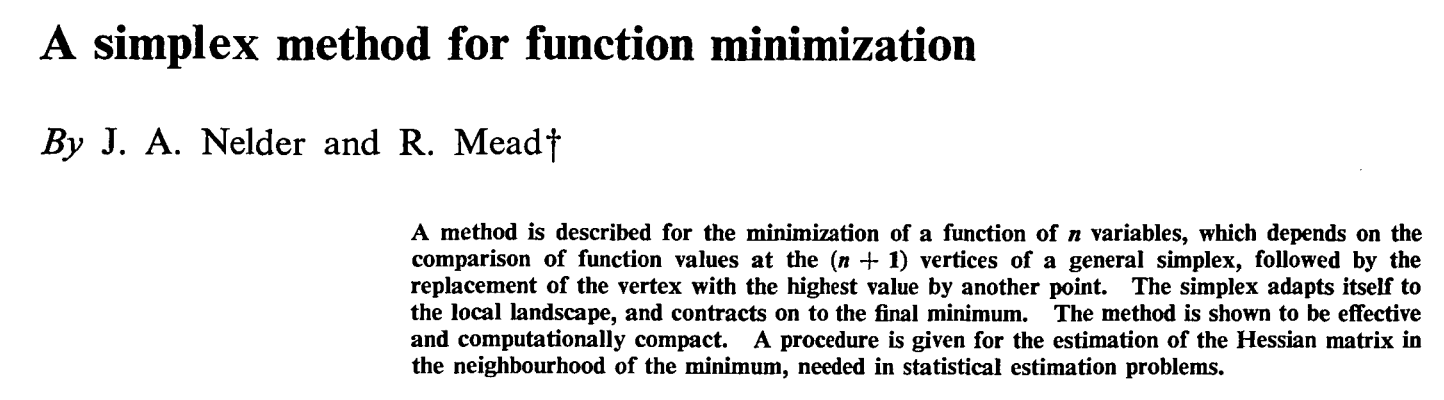

In [2]:
display.Image(path_data+"Nedler_simplex_method.png")

- A simplex is a fundamental geometrical figure used in N-dimensional space. It consists of N + 1 points, also known as vertices, along with all the interconnecting line segments and polygonal faces that connect these points. For example, in two dimensions, a simplex is a triangle, and in three dimensions, it is a tetrahedron.

- In the context of optimization, particularly the downhill simplex method, simplexes are typically non-degenerate, meaning they enclose a finite inner N-dimensional volume. If one point of a non-degenerate simplex is chosen as the origin, the other N points define vector directions that span the N-dimensional vector space. 


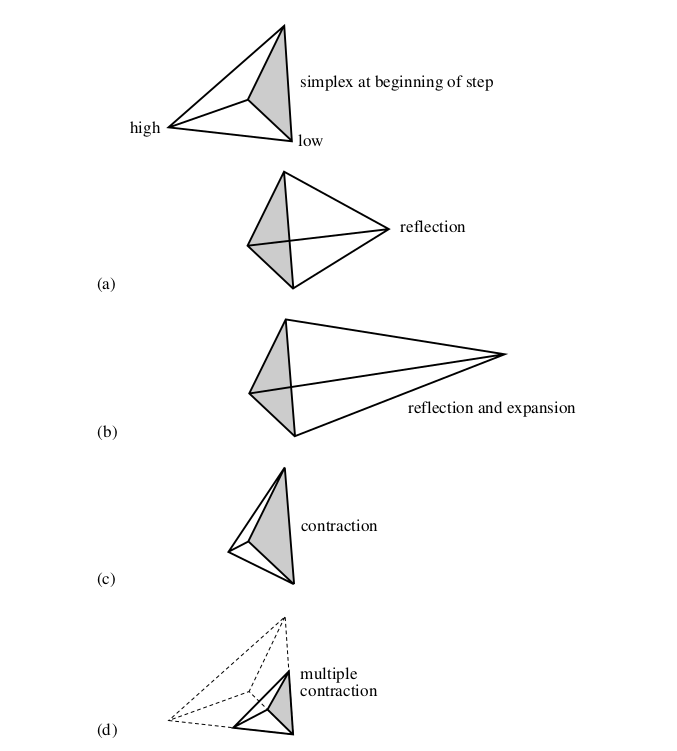

In [3]:
display.Image(path_data+"simplex.png")

Possible outcomes for a step in the downhill simplex method. The simplex at the beginning of the step, here a tetrahedron, is shown, top. The simplex at the end of the step can be any one of (a) a reflection away from the high point, (b) a reflection and expansion away from the high point, (c) a contraction along one dimension from the high point, or (d) a contraction along all dimensions towards the low point. An appropriate sequence of such steps will always converge to a minimum of the function.

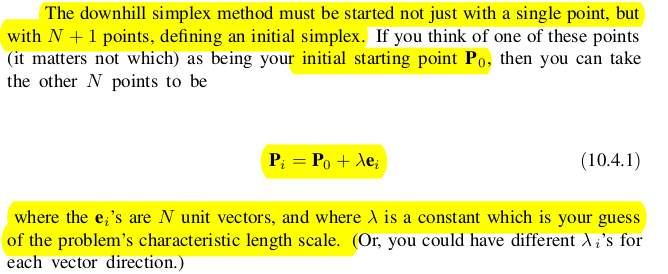

In [4]:
display.Image(path_data+"downhill.png")

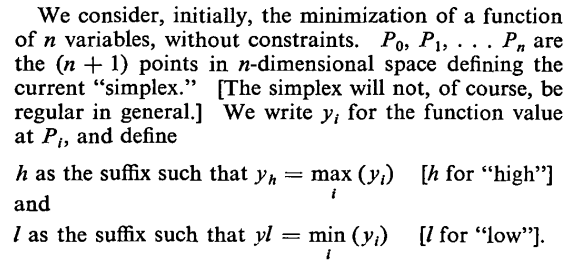

In [5]:
display.Image(path_data+"meth.png")

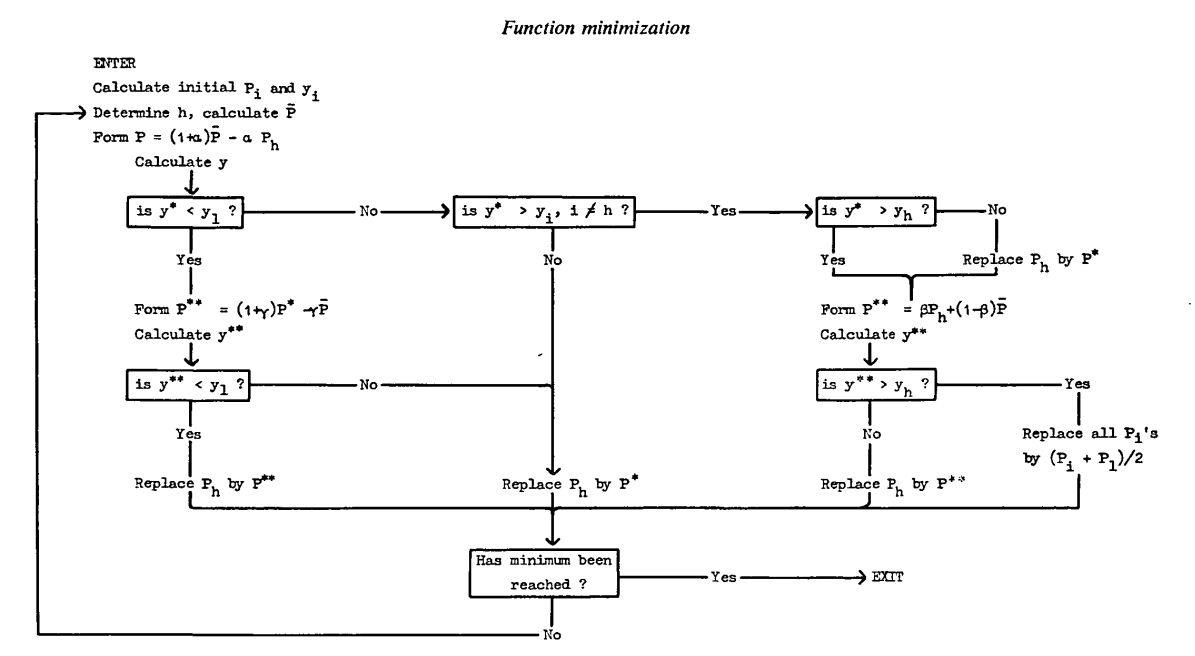

In [6]:
display.Image(path_data+"func_min.png")

# Step-by-Step Algorithm Summary

1- Initialize:

- Start with a simplex defined by ndim+1 vertices and function values at those vertices.

2- Identify Key Vertices:

- Find the best (minimum), worst (maximum), and second-worst vertices.

3- Check Convergence:

If the relative difference between best and worst function values is below ftol, stop.

4- Reflect:

-Reflect the worst point through the centroid of the remaining vertices.

- If the reflection is better than the best point, try an expansion.

- If the reflection is worse than the second-worst point, try a contraction.

5- Shrink:

If contraction fails, shrink all points toward the best point.

6- Update:

- Update the simplex and function values.

- Repeat steps 2–5 until convergence or iteration limit (ITMAX)

In [7]:
TINY = 1.0e-10    # A small number
ITMAX = 5000      # Maximum allowed number of function evaluations

def amotry(p, y, psum, ndim, ihi, fac, funk):  # Performs reflection/expansion/contraction for the vertex ihi.
    """
    Extrapolate by a factor `fac` through the face of the simplex opposite to the high point.
    """
    ptry = psum * (1.0 - fac) / ndim - p[ihi] * ((1.0 - fac) / ndim - fac) # Compute the trial point (ptry) based on the centroid and fac
    ytry = funk(ptry) # Evaluate the objective function at ptry
    
    if ytry < y[ihi]: # If the trial point improves the worst vertex, replace it and update the sum of points
        y[ihi] = ytry
        psum += ptry - p[ihi]
        p[ihi] = ptry

    return ytry # Return the function value at the trial point.

def amoeba(p, y, ndim, ftol, funk, nfunk):
    """
    Multidimensional minimization of function `funk(x)` where x[0..ndim-1]
    is a vector in ndim dimensions, using the downhill simplex method of Nelder and Mead.
    
    Parameters
    ----------
    p : 2D numpy array, shape (ndim+1, ndim) matrix of simplex vertices (each row is a point in n-dimensional space).
    y : 1D numpy array, shape (ndim+1,),Function values evaluated at each vertex of the simplex.
    ndim : Dimensionality of the problem.
    ftol : Convergence tolerance.
    funk : callable, Objective function (function to minimize).
    nfunk : A list used to store the total number of function evaluations (mutable container).

    """
    
    mpts = ndim + 1 # Number of simplex vertices (always ndim + 1).
    psum = np.sum(p, axis=0) # Sum of all vertices across each coordinate dimension (used for reflection/expansion/contraction).
    nfunk[0] = 0

    while True:
        # Determine highest (worst), next-highest, and lowest (best) points  [Find Best, Worst, Second-Worst Vertices]
        ilo = np.argmin(y)
        ihi = np.argmax(y)
        y_copy = y.copy()
        y_copy[ihi] = -np.inf
        inhi = np.argmax(y_copy)

        rtol = 2.0 * abs(y[ihi] - y[ilo]) / (abs(y[ihi]) + abs(y[ilo]) + TINY)  #Relative tolerance rtol measures how close the worst and best function values are.

        # Check for convergence
        if rtol < ftol:
            # Swap best point to first position
            y[0], y[ilo] = y[ilo], y[0]
            p[[0, ilo]] = p[[ilo, 0]]
            break

        if nfunk[0] >= ITMAX: #Iteration limit check
            raise RuntimeError("ITMAX exceeded in amoeba") #Stop if the number of function evaluations exceeds the allowed maximum.

        nfunk[0] += 2   #Reflection and Expansion/Contraction 
        # Attempt reflection
        ytry = amotry(p, y, psum, ndim, ihi, -1.0, funk) # Reflection: Reflect the worst point across the centroid of the remaining points using fac = -1.0.
        if ytry <= y[ilo]:
            # Try expansion
            ytry = amotry(p, y, psum, ndim, ihi, 2.0, funk) # If the reflected point is better than the best point, try expansion to go further in that direction (fac = 2.0).
        elif ytry >= y[inhi]:
            # Try contraction
            ysave = y[ihi]
            ytry = amotry(p, y, psum, ndim, ihi, 0.5, funk) # If the reflected point is worse than the second-worst, try contraction (fac = 0.5)
            if ytry >= ysave: # Shrink Step
                # Perform contraction on all points except best
                for i in range(mpts):
                    if i != ilo:
                        p[i] = 0.5 * (p[i] + p[ilo])
                        y[i] = funk(p[i])
                nfunk[0] += ndim
                psum = np.sum(p, axis=0) # If contraction fails, shrink the entire simplex towards the best point ilo
        else:
            nfunk[0] -= 1   # If reflection neither improves nor worsens, adjust the function count.

    return p, y  # Return the updated simplex points and their function values.


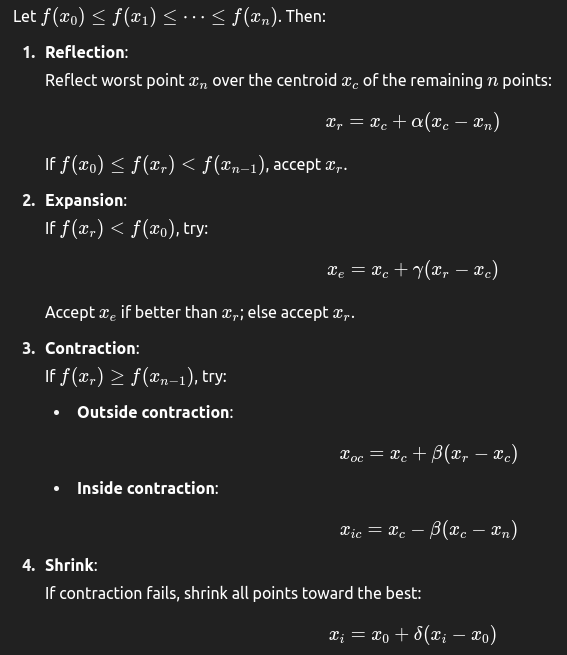

In [8]:
display.Image(path_data+"Nelder-Mead_Steps.png")

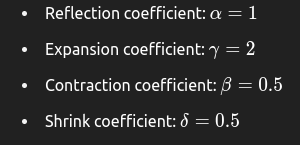

In [9]:
display.Image(path_data+"default_parameters.png", width=300)

In [10]:
#-------------Example of usage --------------#

def func_to_minimize(x):
    return (x[0]-1)**2 + (x[1]+2)**2  # A simple quadratic function

# Initial simplex: 3 points in 2D
p = np.array([[0.0, 0.0],
              [1.0, 0.0],
              [0.0, 1.0]])
y = np.array([func_to_minimize(p[i]) for i in range(p.shape[0])])

nfunk = [0]
p_final, y_final = amoeba(p, y, ndim=2, ftol=1e-6, funk=func_to_minimize, nfunk=nfunk)

print("Minimum found at:", p_final[0])
print("Function value:", y_final[0])
print("Number of function evaluations:", nfunk[0])


Minimum found at: [ 1. -2.]
Function value: 8.49720945568277e-18
Number of function evaluations: 121


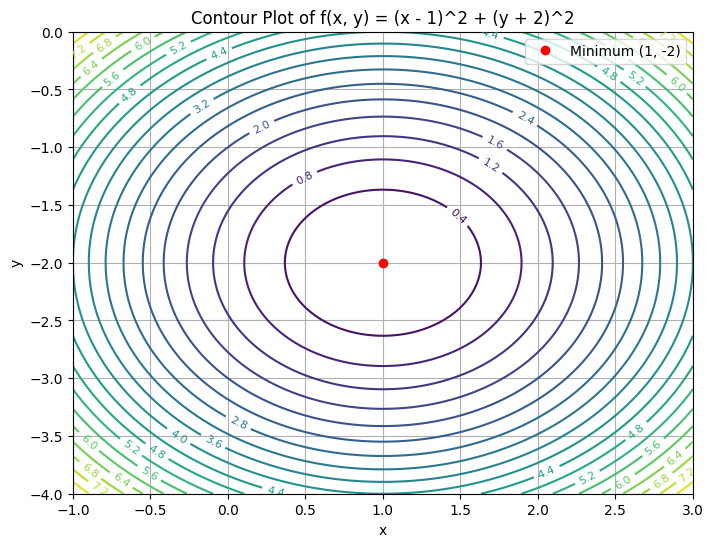

In [11]:
#-------------- Theoretical minimum ----------#

def f(x, y): # quadratic function
    return (x - 1)**2 + (y + 2)**2

# The analytical minimum
x_min, y_min = 1, -2
f_min = f(x_min, y_min)

# Create a grid for plotting
x = np.linspace(-1, 3, 400)
y = np.linspace(-4, 0, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Plot contour and highlight minimum
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=20, cmap="viridis")
plt.clabel(contour, inline=True, fontsize=8)
plt.plot(x_min, y_min, 'ro', label=f"Minimum ({x_min}, {y_min})")
plt.title("Contour Plot of f(x, y) = (x - 1)^2 + (y + 2)^2")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


